In [1]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"

In [2]:
from transformers import MarianTokenizer, MarianMTModel, Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import Dataset
import sacrebleu
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
# Load the cleaned NusaX-MT files
train_df = pd.read_csv("../dataset/train.csv")
valid_df = pd.read_csv("../dataset/valid.csv")
test_df = pd.read_csv("../dataset/test.csv")

# Combine and shuffle the full dataset
combined_df = pd.concat([train_df, valid_df, test_df], ignore_index=True)

# Create an 80/10/10 split
train_df, temp_df = train_test_split(combined_df, test_size=0.2, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Preview a few training samples
print("Sample from training data:")
display(train_df[['english', 'indonesian']].head())

Sample from training data:


,english,indonesian
29,My family and I were looking for a place to ea...,Saya sekeluarga sedang cari tempat makan habis...
535,This place offered indoor and outdoor seats. B...,Tempat ini menyediakan meja kursi di dalam dan...
695,I'm disappointed with the service. I just orde...,Saya kecewa dengan pelayanannya. Barusan saya ...
557,"Seriously, Eiger's stuff are top notch","Eiger, itu barangnya bagus-bagus serius dah."
836,Watching Indonesian films on TV really annoys ...,"Menonton film indonesia di tv ini, kadang biki..."


In [4]:
# Summary statistics of the dataset
summary = {
    "Split": ["Train", "Validation", "Test"],
    "Total Rows": [len(train_df), len(valid_df), len(test_df)],
    "Missing (english)": [
        train_df['english'].isnull().sum(),
        valid_df['english'].isnull().sum(),
        test_df['english'].isnull().sum()
    ],
    "Missing (indonesian)": [
        train_df['indonesian'].isnull().sum(),
        valid_df['indonesian'].isnull().sum(),
        test_df['indonesian'].isnull().sum()
    ]
}

stats_df = pd.DataFrame(summary)
print("\n Dataset Overview:")
display(stats_df)


 Dataset Overview:


,Split,Total Rows,Missing (english),Missing (indonesian)
0,Train,800,0,0
1,Validation,100,0,0
2,Test,100,0,0


In [5]:
# Rename the columns to match expected format
train_data = train_df.rename(columns={"english": "en", "indonesian": "id"})
valid_data = valid_df.rename(columns={"english": "en", "indonesian": "id"})
test_data = test_df.rename(columns={"english": "en", "indonesian": "id"})

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_data[["en", "id"]])
valid_dataset = Dataset.from_pandas(valid_data[["en", "id"]])
test_dataset = Dataset.from_pandas(test_data[["en", "id"]])

# Wrap the translations in a dict format required by MarianMT
def wrap_translation(example):
    return {"translation": {"en": example["en"], "id": example["id"]}}

train_dataset = train_dataset.map(wrap_translation)
valid_dataset = valid_dataset.map(wrap_translation)
test_dataset = test_dataset.map(wrap_translation)

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [6]:
# Load the name of the pretrained model for English to Indonesian translation
model_name = "Helsinki-NLP/opus-mt-en-id"

# Load the tokenizer (this breaks text into subword units)
tokenizer = MarianTokenizer.from_pretrained(model_name)

# Load the pretrained MarianMT model (this will be fine-tuned later)
model = MarianMTModel.from_pretrained(model_name)

In [7]:
print(model)

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(54796, 512, padding_idx=54795)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(54796, 512, padding_idx=54795)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLU()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05

In [8]:
print(model.model.encoder)

MarianEncoder(
  (embed_tokens): Embedding(54796, 512, padding_idx=54795)
  (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
  (layers): ModuleList(
    (0-5): 6 x MarianEncoderLayer(
      (self_attn): MarianAttention(
        (k_proj): Linear(in_features=512, out_features=512, bias=True)
        (v_proj): Linear(in_features=512, out_features=512, bias=True)
        (q_proj): Linear(in_features=512, out_features=512, bias=True)
        (out_proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (activation_fn): SiLU()
      (fc1): Linear(in_features=512, out_features=2048, bias=True)
      (fc2): Linear(in_features=2048, out_features=512, bias=True)
      (final_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
  )
)


In [9]:
print(model.model.decoder)

MarianDecoder(
  (embed_tokens): Embedding(54796, 512, padding_idx=54795)
  (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
  (layers): ModuleList(
    (0-5): 6 x MarianDecoderLayer(
      (self_attn): MarianAttention(
        (k_proj): Linear(in_features=512, out_features=512, bias=True)
        (v_proj): Linear(in_features=512, out_features=512, bias=True)
        (q_proj): Linear(in_features=512, out_features=512, bias=True)
        (out_proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (activation_fn): SiLU()
      (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (encoder_attn): MarianAttention(
        (k_proj): Linear(in_features=512, out_features=512, bias=True)
        (v_proj): Linear(in_features=512, out_features=512, bias=True)
        (q_proj): Linear(in_features=512, out_features=512, bias=True)
        (out_proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (encoder_attn_lay

In [10]:
def tokenize_batch(batch):
    src_texts = [x["en"] for x in batch["translation"]]
    tgt_texts = [x["id"] for x in batch["translation"]]

    # Tokenize source
    model_inputs = tokenizer(src_texts, max_length=128, padding="max_length", truncation=True)

    # Tokenize target (label) side
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(tgt_texts, max_length=128, padding="max_length", truncation=True)

    # Set labels
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [11]:
import torch

tokenized_train = train_dataset.map(
    tokenize_batch,
    batched=True,
    remove_columns=train_dataset.column_names,
    load_from_cache_file=False
)

tokenized_valid = valid_dataset.map(
    tokenize_batch,
    batched=True,
    remove_columns=valid_dataset.column_names,
    load_from_cache_file=False
)

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

c:\Users\eifhe\miniconda3\envs\csc671\Lib\site-packages\transformers\tokenization_utils_base.py:3970: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [12]:
tokenized_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_valid.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

In [13]:
print(tokenized_train[0])

{'input_ids': tensor([  300,   597,    17,     7,   167,   701,    40,    15,   455,    12,
         1070,   414,  2713,    15,  3693,     2,    75,   167, 11559,    59,
         3773,    27,  7159,   195, 22291,    27,     6, 11858,     2, 15978,
           55,   573,    15,  7159,    44,     6,   111,  1153,    16,     6,
         2997,     2,    75,   194,   288,     5,    21,  8392, 36392,    27,
           15,   458,   180,     2,    75,  3089,   178,    15, 37938,  1595,
         1191,   452,     3,    59,   282,  2017, 16554,     2, 15184,   461,
            6,   455,    58,  6518,    17,     6,  1308,    58,  9008,     2,
            0, 54795, 54795, 54795, 54795, 54795, 54795, 54795, 54795, 54795,
        54795, 54795, 54795, 54795, 54795, 54795, 54795, 54795, 54795, 54795,
        54795, 54795, 54795, 54795, 54795, 54795, 54795, 54795, 54795, 54795,
        54795, 54795, 54795, 54795, 54795, 54795, 54795, 54795, 54795, 54795,
        54795, 54795, 54795, 54795, 54795, 54795, 

In [14]:
import evaluate

# Load BLEU scorer
bleu = evaluate.load("sacrebleu")

# Function to decode and compute BLEU
def compute_metrics(eval_preds):
    predictions, labels = eval_preds

    # Handle nested predictions
    if isinstance(predictions[0], list) and isinstance(predictions[0][0], list):
        predictions = [p[0] for p in predictions]

    # Decode predictions and labels
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Replace -100 (used as ignore_index) with pad token ID for decoding
    labels = [[token if token != -100 else tokenizer.pad_token_id for token in label] for label in labels]
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Compute BLEU score
    result = bleu.compute(predictions=decoded_preds, references=[[ref] for ref in decoded_labels])
    return {"bleu": result["score"]}

In [15]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./fine_tuned_final",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    learning_rate=5e-5,
    predict_with_generate=True,
    save_total_limit=2,
    eval_strategy="epoch",
    save_strategy="epoch"
)

In [16]:
from transformers import Seq2SeqTrainer
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# Create the Trainer object
trainer = Seq2SeqTrainer(
  model=model,
  args=training_args,
  train_dataset=tokenized_train,
  eval_dataset=tokenized_valid,
  tokenizer=tokenizer,
  data_collator=data_collator,
  compute_metrics=compute_metrics
)

C:\Users\eifhe\AppData\Local\Temp\ipykernel_44152\624596874.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [17]:
trainer.train()

c:\Users\eifhe\miniconda3\envs\csc671\Lib\site-packages\transformers\data\data_collator.py:740: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)


Epoch,Training Loss,Validation Loss,Bleu
1,No log,0.686403,14.894489
2,No log,0.673001,14.999757
3,No log,0.672104,15.368926
4,No log,0.675497,14.612496
5,0.574400,0.678527,12.478751


c:\Users\eifhe\miniconda3\envs\csc671\Lib\site-packages\transformers\modeling_utils.py:2810: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[54795]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=500, training_loss=0.5744064331054688, metrics={'train_runtime': 193.769, 'train_samples_per_second': 20.643, 'train_steps_per_second': 2.58, 'total_flos': 135593459712000.0, 'train_loss': 0.5744064331054688, 'epoch': 5.0})

In [18]:
metrics = trainer.evaluate(
  max_length=128,
  num_beams=6,
  length_penalty=0.8
)
print(metrics)

{'eval_loss': 0.6785265803337097, 'eval_bleu': 14.27517300654959, 'eval_runtime': 21.3268, 'eval_samples_per_second': 4.689, 'eval_steps_per_second': 0.61, 'epoch': 5.0}


In [19]:
import pandas as pd

# Pull the log history into a DataFrame
history = pd.DataFrame(trainer.state.log_history)

# Show what columns we actually have now
print("logged columns →", history.columns.tolist())

# Show first / last few rows
display(history.head())
display(history.tail())

logged columns → ['eval_loss', 'eval_bleu', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch', 'step', 'loss', 'grad_norm', 'learning_rate', 'train_runtime', 'train_samples_per_second', 'train_steps_per_second', 'total_flos', 'train_loss']


,eval_loss,eval_bleu,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step,loss,grad_norm,learning_rate,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.686403,14.894489,18.3474,5.450,0.709,1.0,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.673001,14.999757,16.0133,6.245,0.812,2.0,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.672104,15.368926,18.1745,5.502,0.715,3.0,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.675497,14.612496,22.7376,4.398,0.572,4.0,400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,5.0,500,0.5744,1.833399,0.0,NaN,NaN,NaN,NaN,NaN


,eval_loss,eval_bleu,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step,loss,grad_norm,learning_rate,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
3,0.675497,14.612496,22.7376,4.398,0.572,4.0,400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,5.0,500,0.5744,1.833399,0.0,NaN,NaN,NaN,NaN,NaN
5,0.678527,12.478751,30.5883,3.269,0.425,5.0,500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,5.0,500,NaN,NaN,NaN,193.769,20.643,2.58,1.355935e+14,0.574406
7,0.678527,14.275173,21.3268,4.689,0.610,5.0,500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


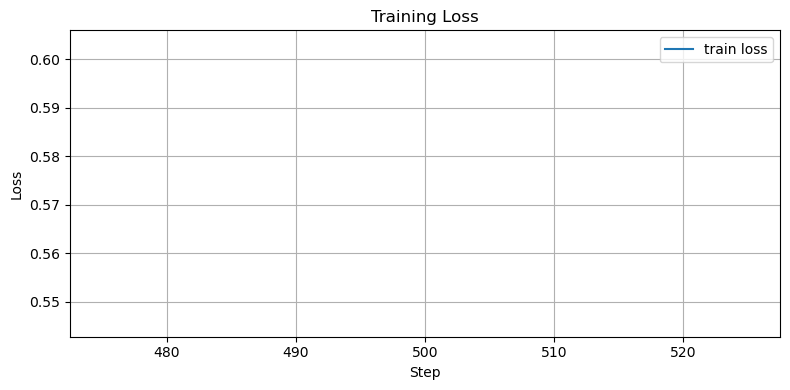

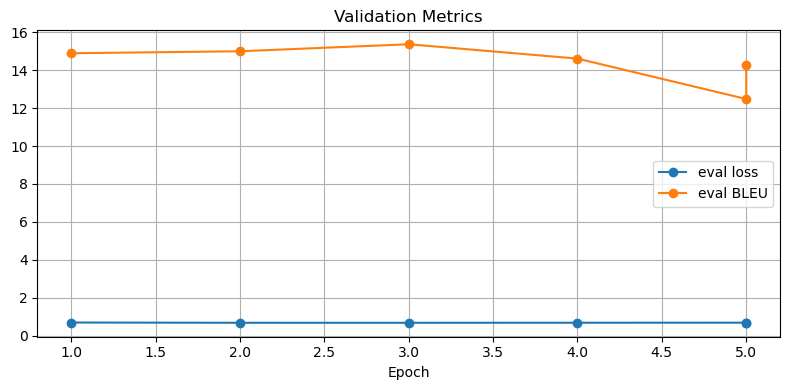

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Split out training vs. eval rows by the keys
if "train_loss" in history:
    train_logs = history[history["train_loss"].notna()]
elif "loss" in history:
    train_logs = history[history["loss"].notna()]
else:
    raise KeyError("No train_loss or loss column in history")

eval_logs = history[history.filter(regex="^eval_").any(axis=1)]

# Plot training loss over steps
plt.figure(figsize=(8,4))
plt.plot(
    train_logs["step"] if "step" in train_logs else train_logs.index,
    train_logs.get("train_loss", train_logs.get("loss")),
    label="train loss"
)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot eval_loss and eval_bleu over epochs 
plt.figure(figsize=(8,4))
if "eval_loss" in eval_logs:
    plt.plot(eval_logs["epoch"], eval_logs["eval_loss"], marker="o", label="eval loss")
if "eval_bleu" in eval_logs:
    plt.plot(eval_logs["epoch"], eval_logs["eval_bleu"], marker="o", label="eval BLEU")
plt.xlabel("Epoch")
plt.title("Validation Metrics")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [21]:
import torch

# Pick MPS or CUDA if available, otherwise CPU
device = (
    torch.device("cuda")
    if torch.cuda.is_available()
    else torch.device("mps")
    if torch.backends.mps.is_available()
    else torch.device("cpu")
)
    
# Print the device being used
print("Using device:", device)

# Move model to that device
model.to(device)
model.eval()

# Prepare some test sentences
examples = [
    "Good morning, how are you?",
    "The quick brown fox jumps over the lazy dog.",
    "Can you translate this sentence into Indonesian?"
]

# Tokenize on CPU, then move the batch to device
batch = tokenizer(
    examples,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=128,
)
batch = {k: v.to(device) for k,v in batch.items()}

# Generate
generated_ids = model.generate(
    input_ids=batch["input_ids"],
    attention_mask=batch["attention_mask"],
    max_length=128,
    num_beams=4,
    length_penalty=0.8,
    early_stopping=True,
)

# Decode back on CPU
generated_ids = generated_ids.cpu().numpy()
translations = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

# Print
for src, tgt in zip(examples, translations):
    print(f"> EN: {src}")
    print(f"< ID: {tgt}\n")

Using device: cuda
> EN: Good morning, how are you?
< ID: Selamat pagi, apa kabar?

> EN: The quick brown fox jumps over the lazy dog.
< ID: Rubah cepat coklat melompat di atas anjing malas.

> EN: Can you translate this sentence into Indonesian?
< ID: Bisa kau terjemahkan kalimat ini ke indonesia?

